In [55]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import math
from struct import *
import base64
import matplotlib.pyplot as plt
from csv import reader
import glob

In [60]:
folder = '/Volumes/PhD_Data/'

filepaths = glob.glob(folder + '/*_2_bt1*')
for i,f in enumerate(filepaths):
    print(str(i) + ': '+ f)

0: /Volumes/PhD_Data/083122_111211_2_bt1_blinktemp_TEST.csv
1: /Volumes/PhD_Data/083122_111033_2_bt1_blinkgyro_TEST.csv
2: /Volumes/PhD_Data/083122_110823_2_bt1_gyrotemp_TEST.csv
3: /Volumes/PhD_Data/083122_110633_2_bt1_gyroonly_TEST.csv
4: /Volumes/PhD_Data/083122_110425_2_bt1_temponly_TEST.csv
5: /Volumes/PhD_Data/083122_110107_2_bt1_blinkonly_TEST.csv
6: /Volumes/PhD_Data/083122_105823_2_bt1_all_TEST.csv


## Parser for our file:

In [69]:
def get_all_data(filepath):
    
    #get raw packets
    logs, blinks, acc, gyro, thermal = [], [], [], [], []
    with open(filepath, 'r') as read_obj:
        csv_reader = reader(read_obj)
        for row in csv_reader:
            if   (row[0]=='l'):
                logs.append(row[1:])

            elif (row[0]=='g'):
                if   (row[2]=='b'):
                    blinks.append(row[1:])
                elif (row[2]=='t'):
                    thermal.append(row[1:])
                elif (row[2]=='a'):
                    acc.append(row[1:])
                elif (row[2]=='g'):
                    gyro.append(row[1:])
    
    blinks_df = pd.DataFrame()
    try:
        for b in blinks:
            blinks_df = pd.concat([blinks_df, parseBlinkRow(b)], axis=0)
        blinks_df.reset_index(inplace=True)
    except:
        pass
    
    gyro_df = pd.DataFrame()
    acc_df = pd.DataFrame()
    try:
        for g in gyro:
            gyro_df = pd.concat([gyro_df, parseXYZRow(g)], axis=0)    
        gyro_df.reset_index(inplace=True)
    
        for a in acc:
            acc_df = pd.concat([acc_df, parseXYZRow(a)], axis=0)    
        acc_df.reset_index(inplace=True)
    except:
        pass
    
    thermal_df = pd.DataFrame()
    try:     
        for t in thermal:
            thermal_df = pd.concat([thermal_df, parseThermalRow(t)], axis=0)    
        thermal_df.reset_index(inplace=True)
    
        thermal_df['nose_temp_C'] = thermal_df.apply(lambda x: convert_nose_temp(x['nose_tp'], x['nose_thermistor']), axis=1)
        thermal_df['temple_temp_C'] = thermal_df.apply(lambda x: convert_temple_temp(x['temple_tp'], x['temple_thermistor']), axis=1)
        thermal_df['differential_C'] = thermal_df['nose_temp_C'] - thermal_df['temple_temp_C']
        thermal_df['differential_C_rolling'] = thermal_df['differential_C'].rolling(5).mean()
    except:
        pass

    return logs, blinks_df, acc_df, gyro_df, thermal_df

def parseBlinkRow(b):
    packetLength = int(b[6])
    blink_df_row = pd.DataFrame(data=[b[0:12] for i in range(packetLength)], columns=['serverTS', 'packetTypeLetter', 'packetType', 'packetNum', 'msFromStart', 'epoch', 'packetSize', 'res0', 'res1', 'res2','res3','res4']) 
    blink_df_row = pd.concat([blink_df_row, pd.Series(data=b[13:], name='data').astype('int32')], axis=1)
    
    blinkSampleRate = 1000 # 1kHz
    blinkSamplePeriod_ms = 1000 * (1/blinkSampleRate) # 1 ms
    blink_df_row["tick_ms"] = blink_df_row['msFromStart'].astype(int) 
    blink_df_row["tick_ms"] -= (packetLength - np.array(range(1, packetLength+1))) * blinkSamplePeriod_ms
    
    blink_df_row["saturated"] = blink_df_row["res0"].astype(int)
    
    return blink_df_row
    
def parseXYZRow(p):
    packetLength = 25
    df_row = pd.DataFrame(data=[p[0:12] for i in range(packetLength)], columns=['serverTS', 'packetTypeLetter', 'packetType', 'packetNum', 'msFromStart', 'epoch', 'packetSize', 'res0', 'res1', 'res2','res3','res4']) 
    df_row = pd.concat([df_row, pd.DataFrame(data=np.array(p[13:]).astype('int32').reshape(-1,5), columns=['x','y','z','imu_tick_ms','tick_ms'])], axis=1)
    return df_row
    
def parseThermalRow(t):
    
    tempSamplePeriod_ms = 100
    numInnerPackets = 4
    rowsInInnerPacket = 5
    
    df_row = pd.DataFrame(data=[t[0:12] for i in range(numInnerPackets*rowsInInnerPacket)], columns=['serverTS', 'packetTypeLetter', 'packetType', 'packetNum', 'msFromStart', 'epoch', 'packetSize', 'res0', 'res1', 'res2','res3','res4']) 
    
    payload = np.array(t[13:]).astype(np.int32).reshape(numInnerPackets, -1)
    
    def flatten(t): return [item for sublist in t for item in sublist]
    reindex = flatten([[*range(i*3,i*3+3)] + [*range(15+i*3, 18+i*3)] + [-2,-1] for i in range(rowsInInnerPacket)])
    proper_payload = payload[:,reindex].reshape(-1,8)
    
    df_row = pd.concat([df_row, pd.DataFrame(data=proper_payload, columns=["temple_tp","temple_thermistor","secondary_temple_tick_ms","nose_tp","nose_thermistor","secondary_nose_tick_ms","tick_ms","epoch"])], axis=1)
    df_row['tick_ms'] -= tempSamplePeriod_ms * np.array([4,3,2,1,0] * numInnerPackets)
    
    return df_row
    
def convert_thermistor_to_K(raw_value):
    # STEP 1. Calc R_thermistor value given ADC_val
    R_divider = 100000
    ADC_max = 4095
    
    R_t = (R_divider * raw_value/ADC_max) / (1 - raw_value/ADC_max)
    
    # STEP 2. Convert R_t to temp
    R_0 = 100000
    T_0 = 298.15
    Beta = 3960
    R_inf = R_0 * math.exp(-Beta/T_0)
    
    Temp_K = Beta / np.log(R_t / R_inf)
    return Temp_K
    
def convert_thermopile_to_C(raw_val, T_ref_K, A, a_0, a_1):
    #STEP 1. Calc V_thermopile based on preamp gain and bias
    V_tp = (((raw_val / 4095) * 3.3) - (1.15+0.6084))/1000.0
    
    #STEP 2. Solve for Temperature!
    f_V_tp = (V_tp - a_0) + a_1 * (V_tp - a_0)**2
    T_obj = (T_ref_K**4 + f_V_tp/A)**0.25
    return (T_obj - 273.15)
    
def convert_nose_temp(raw_val, raw_thermistor):
    A   =  7.8e-10
    a_0 = -2.31e-01
    a_1 =  3.61e-03
    return convert_thermopile_to_C(raw_val, 
                                  convert_thermistor_to_K(raw_thermistor), 
                                  A, a_0, a_1)
    
def convert_temple_temp(raw_val, raw_thermistor):
    A   =  4.21e-10
    a_0 = -3.62e-01
    a_1 =  8.31e-02
    return convert_thermopile_to_C(raw_val, 
                                  convert_thermistor_to_K(raw_thermistor), 
                                  A, a_0, a_1)

ALL SENSORS ON VS. INDIVIDUAL SENSORS


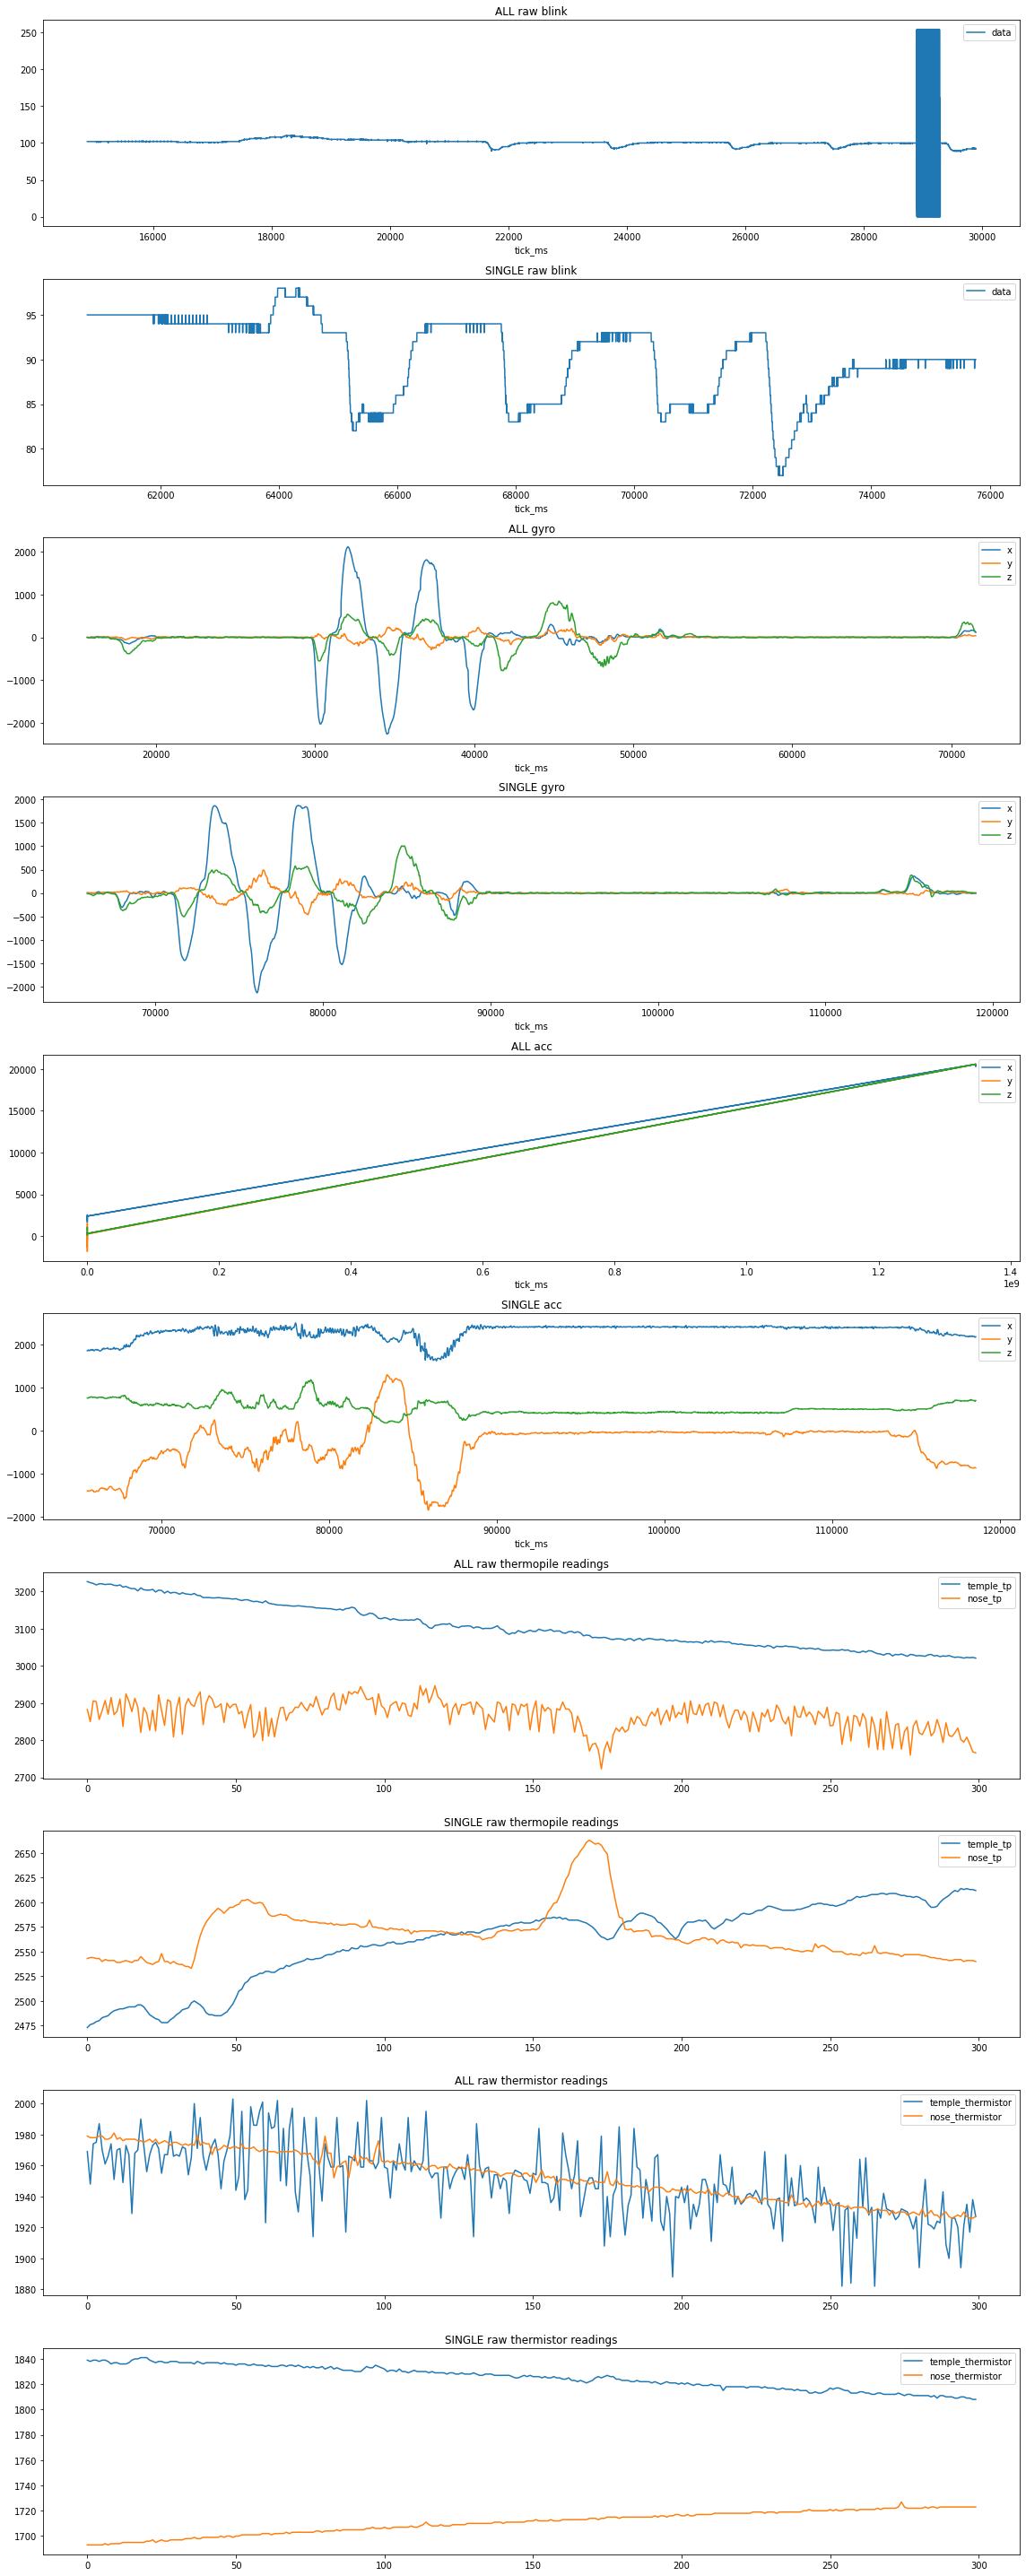

In [91]:
print('ALL SENSORS ON VS. INDIVIDUAL SENSORS')
fig, ax = plt.subplots(10,1,figsize=(16,40)) 

file = glob.glob(folder + '/*_2_bt1_all*')[0]
_, blinks_all, acc_all, gyro_all, thermal_all = get_all_data(file)

##

file = glob.glob(folder + '/*_2_bt1_blinkonly*')[0]
_, blinks_only, _, _, _ = get_all_data(file)

maxlen = min(len(blinks_all), len(blinks_only))
blinks_all[0:maxlen].plot(x='tick_ms', y='data', ax=ax[0], title='ALL raw blink')
blinks_only[0:maxlen].plot(x='tick_ms', y='data', ax=ax[1], title='SINGLE raw blink')

##

file = glob.glob(folder + '/*_2_bt1_gyroonly*')[0]
_, _, acc_only, gyro_only, _ = get_all_data(file)

maxlen = min(len(gyro_all), len(gyro_only))
gyro_all[0:maxlen].plot(x='tick_ms', y=['x','y','z'], ax=ax[2], title='ALL gyro')
gyro_only[0:maxlen].plot(x='tick_ms', y=['x','y','z'], ax=ax[3], title='SINGLE gyro')

maxlen = min(len(acc_all), len(acc_only))
acc_all[0:maxlen].plot(x='tick_ms', y=['x','y','z'], ax=ax[4], title='ALL acc')
acc_only[0:maxlen].plot(x='tick_ms', y=['x','y','z'], ax=ax[5], title='SINGLE acc')

##

file = glob.glob(folder + '/*_2_bt1_temponly*')[0]
_, _, _, _, thermal_only = get_all_data(file)

maxlen = min(len(thermal_all), len(thermal_only))
thermal_all[0:maxlen].plot(use_index=True, y=['temple_tp', 'nose_tp'], ax=ax[6], title='ALL raw thermopile readings')
thermal_only[0:maxlen].plot(use_index=True, y=['temple_tp', 'nose_tp'], ax=ax[7], title='SINGLE raw thermopile readings')

thermal_all[0:maxlen].plot(use_index=True, y=['temple_thermistor','nose_thermistor'], ax=ax[8], title='ALL raw thermistor readings')
thermal_only[0:maxlen].plot(use_index=True, y=['temple_thermistor','nose_thermistor'], ax=ax[9], title='SINGLE raw thermistor readings')

plt.tight_layout()


Initially, it looks like:
- the gyro is fine regardless.
- the accelerometer and blink get digital noise bursts that completely disrupt.  We can probably pretty easily remove these artifacts and throw away that period with some simple filtering algorithm.
- we can see serious movement artifacts when the head is turning due to the window light in the space
- 

[100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
 100 100 100 100 100 100 100 100 100  98 100 100 100 100  53   9 203 254
  11   2   0   0  47   0   0   0 183 113   0   0  53   9 193 254  11   2
   0   0   5   0   0   0 206 113   0   0  72   9 193 254  11   2   0   0
  36   0   0   0 244 113   0   0  72   9 203 254  21   2   0   0   3   0
   0   0  13 114   0   0  72   9 203 254  21   2   0   0  20   0   0   0
  49 114   0   0  53   9 213 254  11   2   0   0   9   0   0   0  76 114
   0   0  53   9 213 254  11   2   0   0   7   0   0   0 108 114   0   0
  43   9 222 254  11   2   0   0  51   0   0   0 148 114   0   0  53   9
 232 254  21   2   0   0   5   0   0   0 170 114   0   0  63   9 232 254
  11   2   0   0  34   0   0   0 208 114   0   0  63   9 232 254  11   2
   0   0   5   0   0   0 233 114   0   0  43   9 222 254  21   2   0   0
  16   0   0   0  11 115   0   0  63   9 222 254  2

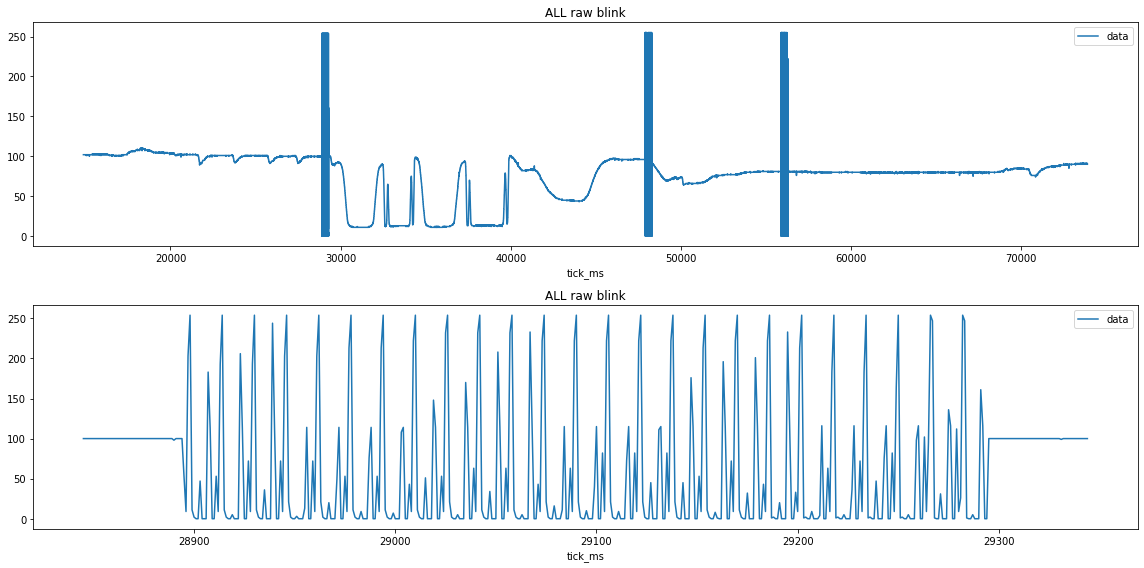

In [128]:
fig, ax = plt.subplots(2, 1, figsize=(16,8))
blinks_all.plot(x='tick_ms', y='data', ax=ax[0], title='ALL raw blink')
blinks_all[13950:14450].plot(x='tick_ms', y='data', ax=ax[1], title='ALL raw blink')
plt.tight_layout()

print(blinks_all[13950:14450]['data'].values)

### Takeaways here

Seems we have interruptions here, 3 over 50 seconds; each interruption is exactly 400 values (1 packet).  Values jump from 0 to 254.  Should easily detect corrupt packet.

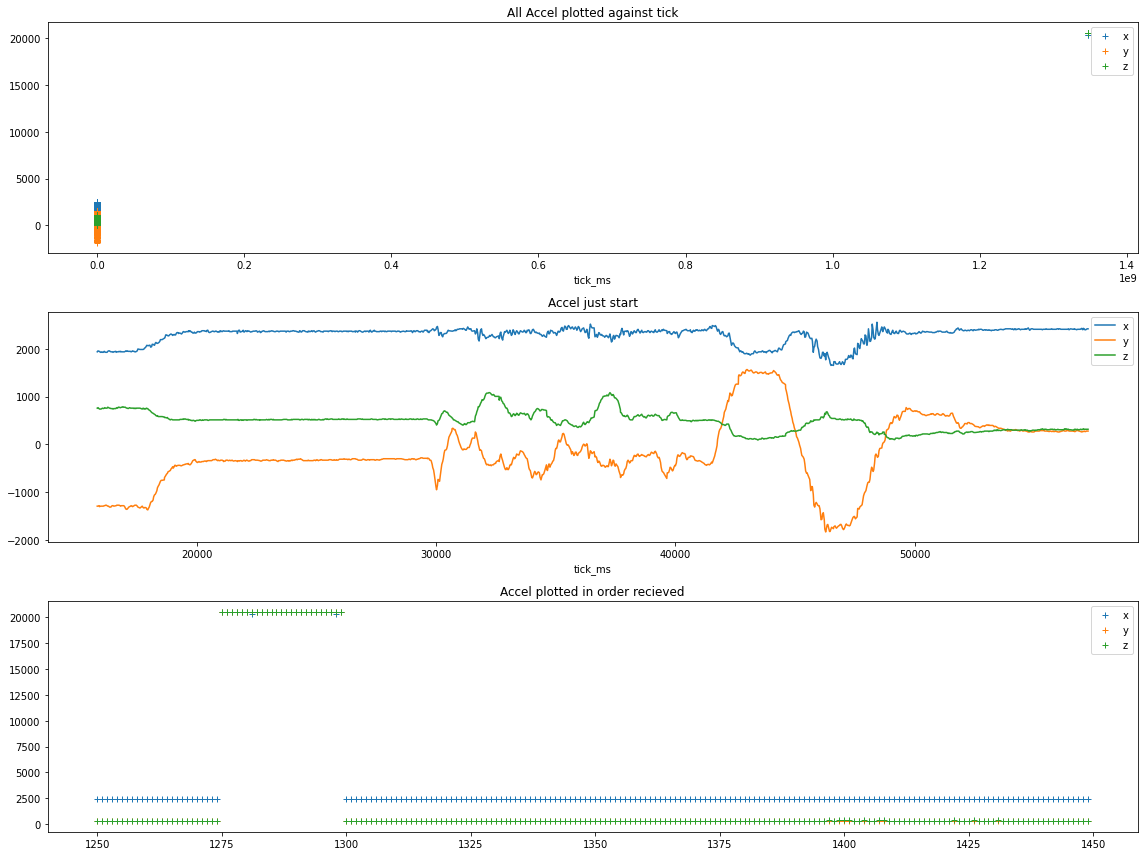

In [123]:
fig, ax = plt.subplots(3, 1, figsize=(16,3*4))
acc_all.plot(x='tick_ms', y=['x','y','z'], ax=ax[0], style='+', title='All Accel plotted against tick')
acc_all[0:-500].plot(x='tick_ms', y=['x','y','z'], ax=ax[1], title='Accel just start')
acc_all[-500:-300].plot(use_index=True, y=['x','y','z'], ax=ax[2], style='+', title='Accel plotted in order recieved')
plt.tight_layout()

### Takeaways for accel (All sensors, zoomed on acc data)

seems we have a random, totally corrupt packet (25 values), where all the values huge.  If we plot it against the tick values reported (as in the first plot) we see we've gotten a crazy huge tick value that makes no sense.  

Easy to throw away simply corrupt packets based on packetID/timestamp/value sanity checks

TEMP SENSING ISSUES


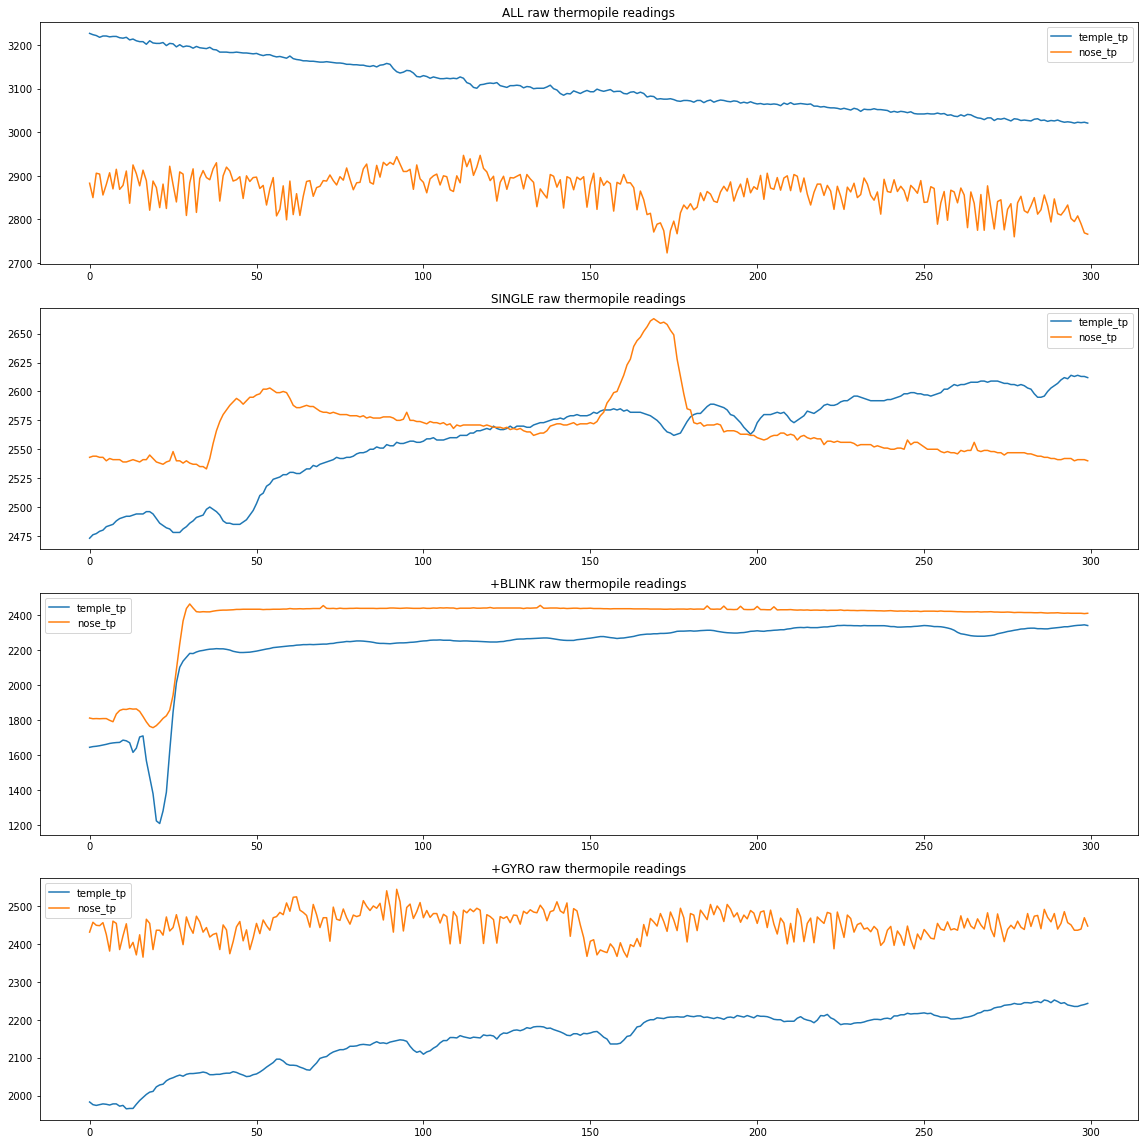

In [131]:
print('TEMP SENSING ISSUES')

file = glob.glob(folder + '/*_2_bt1_all*')[0]
_, blinks_all, acc_all, gyro_all, thermal_all = get_all_data(file)

file = glob.glob(folder + '/*_2_bt1_temponly*')[0]
_, _, _, _, thermal_only = get_all_data(file)

file = glob.glob(folder + '/*_2_bt1_blinktemp*')[0]
_, _, _, _, thermal_blink = get_all_data(file)

file = glob.glob(folder + '/*_2_bt1_gyrotemp*')[0]
_, _, _, _, thermal_gyro = get_all_data(file)


maxlen = min(len(thermal_all), len(thermal_only), len(thermal_blink), len(thermal_gyro))

fig, ax = plt.subplots(4,1,figsize=(16,16)) 
thermal_all[0:maxlen].plot(use_index=True, y=['temple_tp', 'nose_tp'], ax=ax[0], title='ALL raw thermopile readings')
thermal_only[0:maxlen].plot(use_index=True, y=['temple_tp', 'nose_tp'], ax=ax[1], title='SINGLE raw thermopile readings')
thermal_blink[0:maxlen].plot(use_index=True, y=['temple_tp', 'nose_tp'], ax=ax[2], title='+BLINK raw thermopile readings')
thermal_gyro[0:maxlen].plot(use_index=True, y=['temple_tp', 'nose_tp'], ax=ax[3], title='+GYRO raw thermopile readings')
plt.tight_layout()


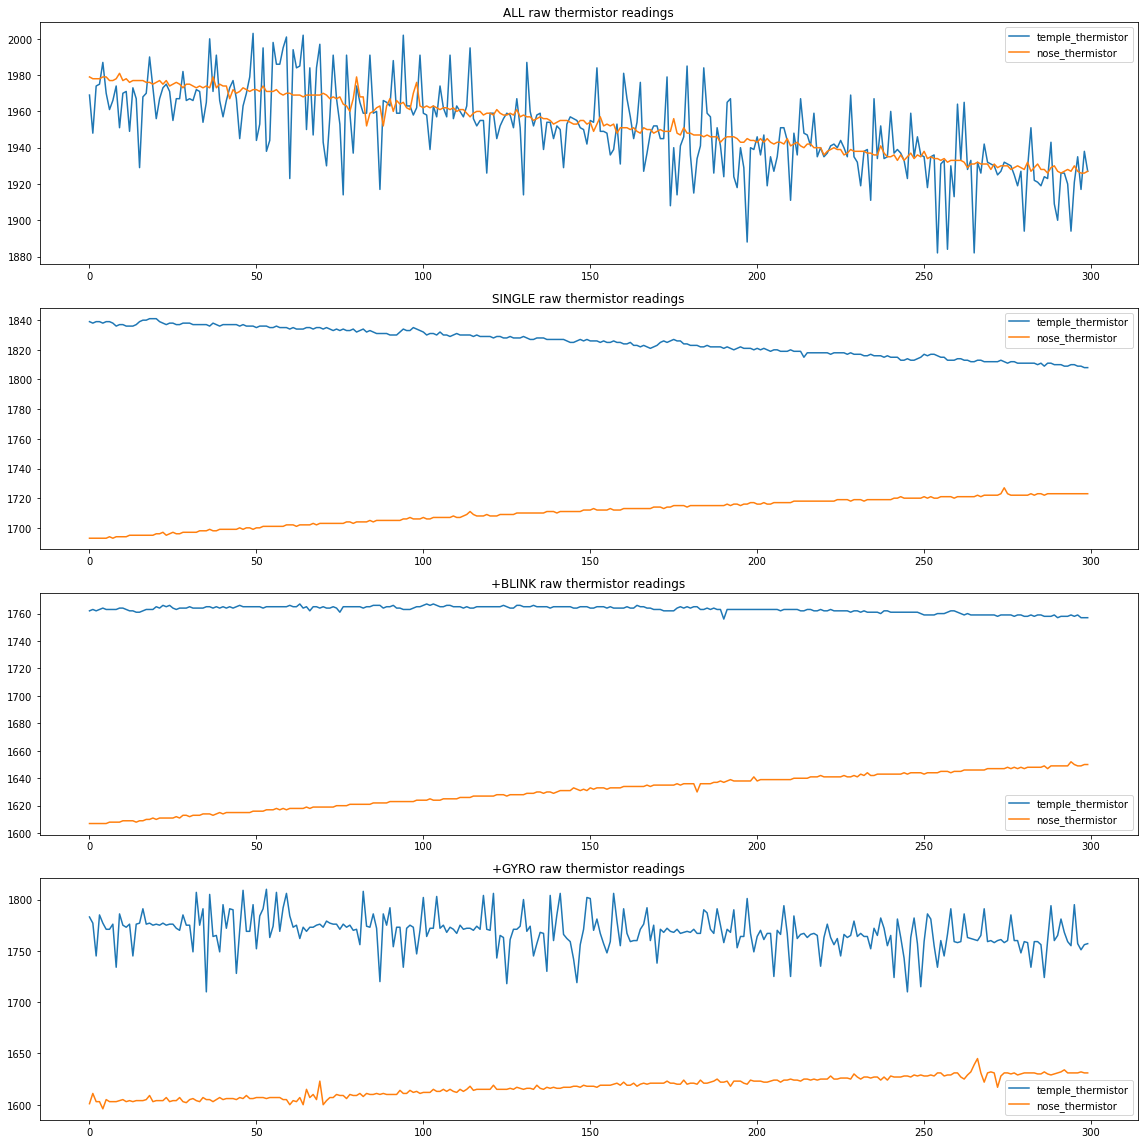

In [132]:
fig, ax = plt.subplots(4,1,figsize=(16,16)) 
thermal_all[0:maxlen].plot(use_index=True, y=['temple_thermistor','nose_thermistor'], ax=ax[0], title='ALL raw thermistor readings')
thermal_only[0:maxlen].plot(use_index=True, y=['temple_thermistor','nose_thermistor'], ax=ax[1], title='SINGLE raw thermistor readings')
thermal_blink[0:maxlen].plot(use_index=True, y=['temple_thermistor','nose_thermistor'], ax=ax[2], title='+BLINK raw thermistor readings')
thermal_gyro[0:maxlen].plot(use_index=True, y=['temple_thermistor','nose_thermistor'], ax=ax[3], title='+GYRO raw thermistor readings')
plt.tight_layout()

### Takeaways

Gyro messes with thermopile data: adds noise to temple thermistor and nose thermopile most obviously

In [51]:
def pull_rawdata_frisson(filepath):
    cap_data = pd.read_csv(filepath, header=None)
    
    def decodeString(input):
        return base64.b64decode(input)

    headerTypes = "HHIIIIIIII"
    size_of_header = calcsize(headerTypes)
    headerLabels = ["packetType","packetID","msFromStart","epoch","payloadLength","res0","res1","res2","res3", "res4"]
    
    def decodeHeader(input):
        packetType, packetID, msFromStart, epoch, payloadLength, res0, res1, res2, res3, res4 = unpack(headerTypes,input[:size_of_header])
        return packetType, packetID, msFromStart, epoch, payloadLength, res0, res1, res2, res3, res4

    cap_data["decoded"] = cap_data[1].apply(decodeString)

    cap_data["decoded_header"]=cap_data["decoded"].apply(decodeHeader)
    cap_header_data = cap_data["decoded_header"].apply(pd.Series)
    cap_header_data.columns = headerLabels
    cap_data = cap_data.join(cap_header_data)

    return cap_data

def frisson_data(filepath, packetType=5):
    cap_data = pull_rawdata_frisson(filepath)
    df = cap_data[cap_data["packetType"] == packetType].reset_index(drop=True)
    df.drop_duplicates(inplace=True)
    return df


def frisson_blink(filepath):
    df = frisson_data(filepath, 5)

    blinkTypes = "B"
    size_of_blink = calcsize(blinkTypes)
    blinkLabels = ["data"]
    blinkSampleRate = 1000 # 1kHz
    blinkSamplePeriod_ms = 1000 * (1/blinkSampleRate) # 1 ms

    def parseBlink(input_df):
        length_of_payload = input_df["payloadLength"]
        num_of_blink_samples_in_payload = int(length_of_payload/size_of_blink)

        headerTypes = "HHIIIIIIII"
        size_of_header = calcsize(headerTypes)
        headerLabels = ["packetType","packetID","msFromStart","epoch","payloadLength","res0","res1","res2","res3", "res4"]
    
        # remove the header prefix
        payload = input_df["decoded"]
        payload = payload[size_of_header:]
        
        blink_samples = unpack(str(num_of_blink_samples_in_payload)+blinkTypes, payload)
        new_df = pd.DataFrame(blink_samples, columns=["data"])
        new_df["packetID"] = input_df["packetID"]
        new_df["epoch"] = input_df["epoch"] # not used
        new_df["serverTS"] = input_df[0]
        timeStamps = np.arange(input_df["msFromStart"] - num_of_blink_samples_in_payload * blinkSamplePeriod_ms + 1, input_df["msFromStart"] + 1, blinkSamplePeriod_ms)
        new_df["msFromStart"] = timeStamps.astype(int)
        new_df["saturated"] = input_df["res0"] # if 1, the emitter is off because there is too much NIR light in the room which causes sensor to saturate

        return new_df

    blink_df = pd.DataFrame()
    for index, row in df.iterrows():
        blink_df = blink_df.append(parseBlink(row))
    
    return blink_df
    
def frisson_thermal(filepath):
    df = frisson_data(filepath, 6)

    tempTypes = "HHI"
    tempSuffixTypes = "II"
    tempPacketType = tempTypes * 5 + tempTypes * 5 + tempSuffixTypes
    size_of_tempPacketType = calcsize(tempPacketType)
    tempLabels = ["temple_tp","temple_thermistor","secondary_temple_tick_ms","nose_tp","nose_thermistor","secondary_nose_tick_ms","tick_ms","epoch"]
    tempSuffixLabels = ["tick_ms","epoch"]
    tempSamplePeriod_ms = 100

    def flatten(t):
        return [item for sublist in t for item in sublist]

    def parseThermal(input_df):
        length_of_payload = input_df["payloadLength"]
        num_of_thermal_samples_in_payload = int(length_of_payload/size_of_tempPacketType)

        headerTypes = "HHIIIIIIII"
        size_of_header = calcsize(headerTypes)
        headerLabels = ["packetType","packetID","msFromStart","epoch","payloadLength","res0","res1","res2","res3", "res4"]
    
        # remove the header prefix
        payload = input_df["decoded"]
        payload = payload[size_of_header:]

        corePacketLength = 6

        new_df = pd.DataFrame(columns=tempLabels)
        indicies = np.array([0,1,2,3,4,5,6,7])

        for i in range(num_of_thermal_samples_in_payload):
            thermal_samples = np.array(unpack(tempPacketType, payload[i*size_of_tempPacketType:i*size_of_tempPacketType+size_of_tempPacketType]))
            thermal_samples_temp = []
            for j in range(5):
                thermal_samples_temp.append(thermal_samples[(j*3):(j*3+3)])
                thermal_samples_temp.append(thermal_samples[(15+j*3):(15+j*3+3)])

            thermal_samples_temp.append(thermal_samples[-2:])
            thermal_samples = np.array(flatten(thermal_samples_temp))
            # thermal_samples_temp.flatten()

            for j in range(5):
                df_length = len(new_df)
                new_indicie = indicies + corePacketLength * j
                new_indicie[-2] = -2
                new_indicie[-1] = -1
                new_df.loc[df_length] = thermal_samples[new_indicie]
                new_df.at[df_length,"tick_ms"] = new_df.at[df_length,"tick_ms"] - (4-j) * tempSamplePeriod_ms

        new_df["serverTS"] = input_df[0]
        return(new_df)
    
    thermal_df = pd.DataFrame()
    for index, row in df.iterrows():
        thermal_df = thermal_df.append(parseThermal(row))

    return thermal_df

def frisson_acc_or_gyro(filepath, packetType=7):
    df = frisson_data(filepath, packetType)

    threeAxisTypes = "hhhII"
    size_of_threeAxis = calcsize(threeAxisTypes)
    threeAxisLabels = ["x","y","z","imu_tick_ms","tick_ms"]

    def parseThreeAxis(input_df):
        length_of_payload = input_df["payloadLength"]
        num_of_three_axis_samples_in_payload = int(length_of_payload/size_of_threeAxis)

        headerTypes = "HHIIIIIIII"
        size_of_header = calcsize(headerTypes)
        headerLabels = ["packetType","packetID","msFromStart","epoch","payloadLength","res0","res1","res2","res3", "res4"]
    
        # remove the header prefix
        payload = input_df["decoded"]
        payload = payload[size_of_header:]

        new_df = pd.DataFrame(columns=threeAxisLabels)
        for i in range(num_of_three_axis_samples_in_payload):
            three_axis_samples = unpack(threeAxisTypes, payload[i*size_of_threeAxis:(i+1)*size_of_threeAxis])
            if(three_axis_samples[-1]>=300000000): # an error was found where some samples are corrupted so skipping them
                print("Corrupted sample found:")
                print(three_axis_samples)
                continue 
            df_length = len(new_df)
            new_df.loc[df_length] = three_axis_samples

        new_df["serverTS"] = input_df[0]
        new_df["msFromStart"] = input_df["msFromStart"]
        
        return new_df

    acc_df = pd.DataFrame()
    for index, row in df.iterrows():
        acc_df = acc_df.append(parseThreeAxis(row))
    acc_df = acc_df.reset_index()
    return acc_df

def frisson_acc(filepath):
    return frisson_acc_or_gyro(filepath, 7)

def frisson_gyro(filepath):
    return frisson_acc_or_gyro(filepath, 9)

'''
blink = frisson_blink(filepaths[n])
acc = frisson_acc(filepaths[n])
gyro = frisson_gyro(filepaths[n])
thermal = frisson_thermal(filepaths[n])
'''

'\nblink = frisson_blink(filepaths[n])\nacc = frisson_acc(filepaths[n])\ngyro = frisson_gyro(filepaths[n])\nthermal = frisson_thermal(filepaths[n])\n'

In [52]:
def pull_rawdata_myapp(filepath, datatype='b'):

    logs, blinks, acc, gyro, thermal = [], [], [], [], []
    
    with open(filepath, 'r') as read_obj:
        csv_reader = reader(read_obj)
        for row in csv_reader:
            if   (row[0]=='l'):
                logs.append(row[1:])
        
            elif (row[0]=='g'):
                if   (row[2]=='b'):
                    blinks.append(row[1:])
                elif (row[2]=='t'):
                    thermal.append(row[1:])
                elif (row[2]=='a'):
                    acc.append(row[1:])
                elif (row[2]=='g'):
                    gyro.append(row[1:])
    if (datatype=='b'):
        return blinks
    if (datatype=='t'):
        return thermal
    if (datatype=='a'):
        return acc
    if (datatype=='g'):
        return gyro
        
        
def gyro_data(gyros):
    full_data = []
    for g in gyros: 
        header = g[:12]
        payload = g[13:]
        
        #first x,y,z vals are trash, skip [1:]
        for i in range(0,25):
            full_data.append(np.array(payload[i*5:i*5+3])) 
        #print(header, len(payload))
    fig, ax = plt.subplots(figsize=(16,4))
    full_data = np.array(full_data).astype(float)

    plt.locator_params(nbins=4)
    plt.plot(full_data[:,0])
    plt.plot(full_data[:,1])
    plt.plot(full_data[:,2])
    
    ymin, ymax = ax.get_ylim()
    custom_ticks = np.linspace(ymin, ymax, 4, dtype=int)
    ax.set_yticks(custom_ticks)
    ax.set_yticklabels(custom_ticks)

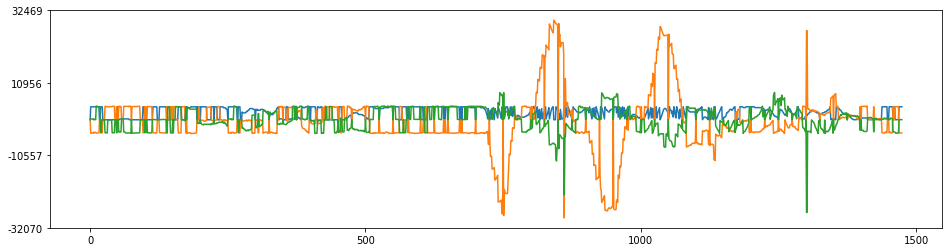

In [53]:
n=12
gyro1 = pull_rawdata_myapp(filepaths[n], 'g')
gyro_data(gyro1) 

0      CQAAAGgVAAAAAAAAkAEAAAAAAAAAAAAAAAAAAAAAAAAAAA...
1      BwAAAPAVAAAAAAAAkAEAAAAAAAAAAAAAAAAAAAAAAAAAAA...
2      CQABAHwXAAAAAAAAkAEAAAAAAAAAAAAAAAAAAAAAAAAAAA...
3      BwABAPQYAAAAAAAAkAEAAAAAAAAAAAAAAAAAAAAAAAAAAA...
4      CQACALEZAAAAAAAAkAEAAAAAAAAAAAAAAAAAAAAAAAAAAA...
                             ...                        
164    CQA0AA59AAAAAAAAkAEAAAAAAAAAAAAAAAAAAAAAAAAAAA...
165    BQBIAGl7AAAAAAAAkAEAAAAAAAAAAAAAAAAAAAAAAAAAAA...
166    BQBJAPl8AAAAAAAAkAEAAAAAAAAAAAAAAAAAAAAAAAAAAA...
167    BQBKAMF9AAAAAAAAyAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...
168    BwAiAMR+AAAAAAAAkAEAAAAAAAAAAAAAAAAAAAAAAAAAAA...
Name: 1, Length: 169, dtype: object


<AxesSubplot:xlabel='tick_ms'>

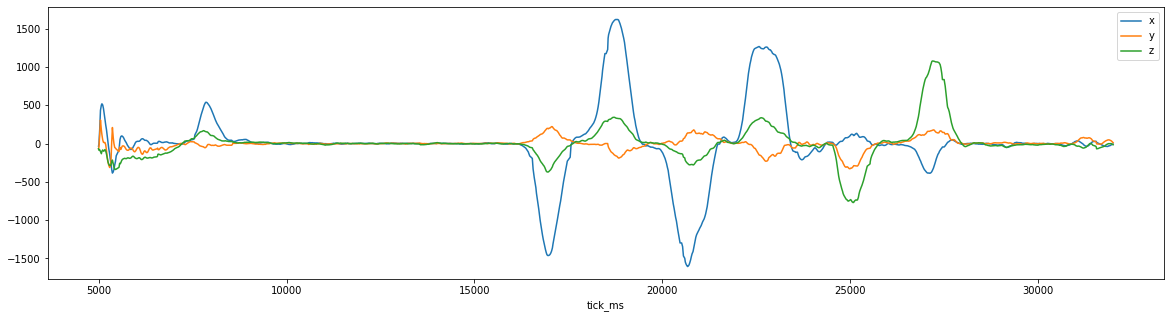

In [54]:
n=13
gyro2 = frisson_gyro(filepaths[n])
fig, ax = plt.subplots(figsize=(20,5))
gyro2.plot(x="tick_ms",y=["x","y","z"], ax=ax)

In [44]:
gyro2.head()

,index,x,y,z,imu_tick_ms,tick_ms,serverTS,msFromStart
0,0,-34,-67,-67,58,4992,2022-08-28 18:48:54,5480
1,1,-2,-43,-88,27,5003,2022-08-28 18:48:54,5480
2,2,186,117,-82,21,5023,2022-08-28 18:48:54,5480
3,3,434,307,-106,25,5043,2022-08-28 18:48:54,5480
4,4,502,175,-133,34,5067,2022-08-28 18:48:54,5480


In [46]:
g1 = pd.DataFrame(gyro1)
g1.head()

#"packetType","packetID","msFromStart","epoch","payloadLength","res0","res1","res2","res3"

,0,1,2,3,4,5,6,7,8,9,...,128,129,130,131,132,133,134,135,136,137
0,2022-08-28T22:50:46.344Z,g,9,83,47300,0,400,NaN,NaN,NaN,...,0,32,48,10486272,2153449472,0,48,64,7340288,2153449728
1,2022-08-28T22:50:46.591Z,g,9,84,47757,0,400,NaN,NaN,NaN,...,0,3840,-3841,7340288,2698707968,3840,-3857,16,7340288,2685076992
2,2022-08-28T22:50:46.839Z,g,9,85,48258,0,400,NaN,NaN,NaN,...,0,3952,-3985,5243136,3237675776,0,3952,-4001,9437440,3227190528
3,2022-08-28T22:50:47.100Z,g,9,86,48745,0,400,NaN,NaN,NaN,...,3840,-3841,0,9437440,3764060928,0,3872,-3841,11534592,3768255488
4,2022-08-28T22:50:47.312Z,g,9,87,49234,0,400,NaN,NaN,NaN,...,0,16,32,9437440,11272704,0,48,48,7340288,15467264


In [21]:
n=13
print(filepaths[n])
blink = frisson_blink(filepaths[n])
acc = frisson_acc(filepaths[n])
gyro = frisson_gyro(filepaths[n])
thermal = frisson_thermal(filepaths[n])

/Volumes/PhD_Data/glasses_bt1_full_frisson.csv


<AxesSubplot:xlabel='tick_ms'>

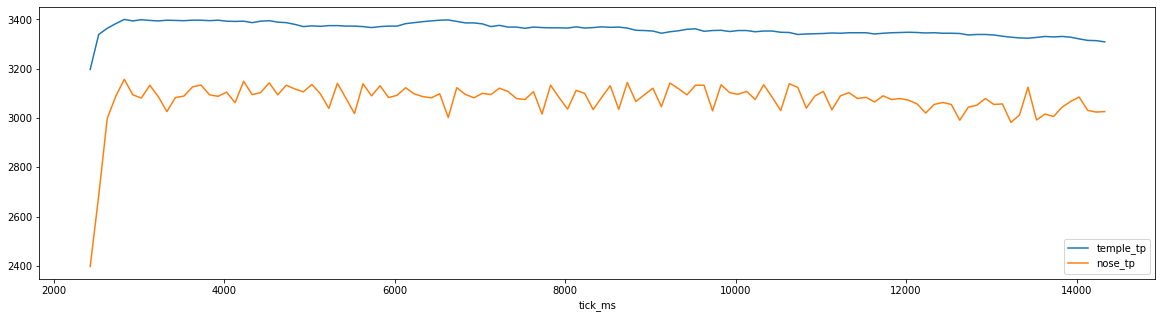

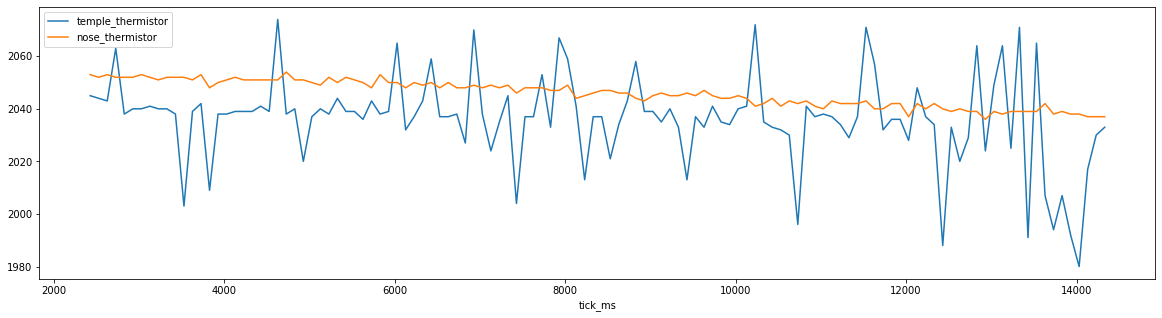

In [26]:
fig, ax = plt.subplots(figsize=(20,5))
thermal.plot(x="tick_ms",y="temple_tp", ax=ax)
thermal.plot(x="tick_ms",y="nose_tp", ax=ax)

fig, ax = plt.subplots(figsize=(20,5))
thermal.plot(x="tick_ms",y="temple_thermistor", ax=ax)
thermal.plot(x="tick_ms",y="nose_thermistor", ax=ax)



<AxesSubplot:xlabel='tick_ms'>

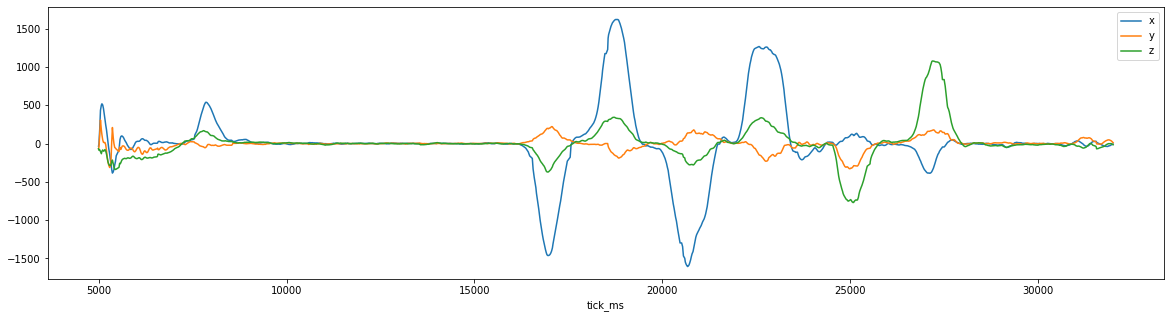

In [28]:
fig, ax = plt.subplots(figsize=(20,5))
gyro.plot(x="tick_ms",y=["x","y","z"], ax=ax)

<AxesSubplot:xlabel='tick_ms'>

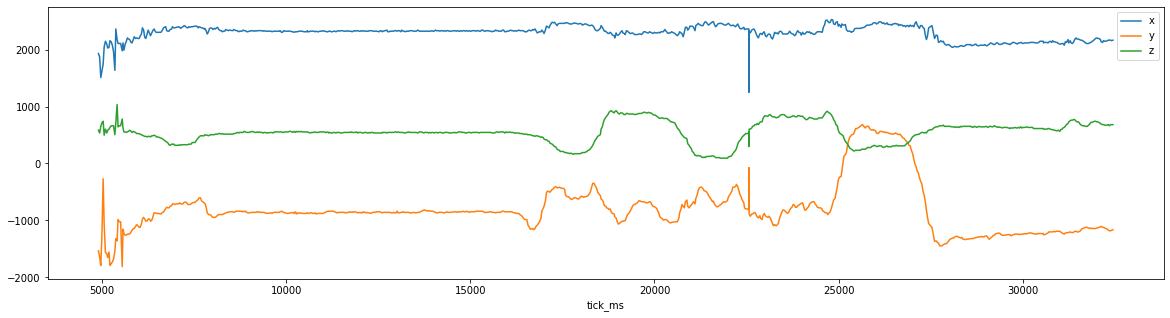

In [29]:
fig, ax = plt.subplots(figsize=(20,5))
acc.plot(x="tick_ms",y=["x","y","z"], ax=ax)

<AxesSubplot:xlabel='msFromStart'>

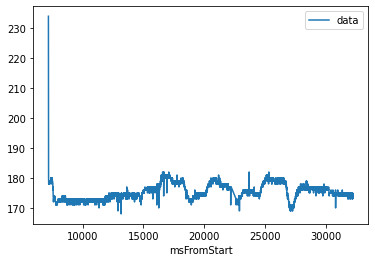

In [32]:
blink.plot(x='msFromStart', y="data")